# User Guide: Simulation and Exact Computation for Chip-Clearing Games

This program analyzes winning probabilities in **chip-clearing games**.  
It combines **simulation** (Monte Carlo experiments) with **exact computation**
(using rational arithmetic via `Fraction`).

---

## Inputs

- **p**: hit probabilities of the fields (list, summing to 1).  
  Example: `p = [1/2, 1/3, 1/6]`

- **A**: chip allocation of player A (list of nonnegative integers).  
  Example: `A = [3, 2, 1]`

- **B**: chip allocation of player B.  
  Example: `B = [4, 2, 0]`

- **n_values**: list of different sample sizes used for the simulation.  
  Example: `n_values = [100, 400, 1600]`

---

## Usage Notes

- The relevant parameters are located at the end of the code:

```python
p = [Fraction(1, 2), Fraction(1, 3), Fraction(1, 6)]
A = [3, 2, 1]
B = [4, 2, 0]
n_values = [100, 400, 1600]

```
### ▶️ Running the Program

- Click inside the code cell.
- Press `Shift + Enter` to start the computation.  
  Alternatively, click **▶ Run** in the toolbar at the top.
- Use **Run → Run All Cells** to execute all cells at once.


---

## Outputs

1. **Simulation results**:
   - relative frequencies (`phat`) for “A wins”, “B wins”, and “draw”
   - 95% confidence intervals (Wilson intervals)
   - deviation from the exact value  

   → Output is shown in tabular form in the console.

2. **Exact computation** (using `Fraction`):  
   - provides **exact rational values** for the three probabilities  
   - additionally displayed as **decimal values**

3. **Plot** (bar chart):  
   - blue bars = simulation results  
   - black error bars = uncertainty (confidence intervals)  
   - red dots = exact values  
   - comparison across all chosen sample sizes side by side  

---

## Things to Try

- Change the probabilities `p` (e.g. uniform or highly skewed).  
- Vary the chip allocations of players A and B.  
- Modify the sample sizes `n_values` (e.g. 100, 1 000, 10 000).

---


--- Results for n = 100 ---
A wins         : phat = 0.50000, CI = (0.40383 – 0.59617), deviation = 0.00753, exact = 1181921/2400000
B wins         : phat = 0.26000, CI = (0.18405 – 0.35371), deviation = 0.00609, exact = 65/256
Draw           : phat = 0.24000, CI = (0.16691 – 0.33233), deviation = 0.01363, exact = 9511/37500

--- Results for n = 400 ---
A wins         : phat = 0.49250, CI = (0.44381 – 0.54133), deviation = 0.00003, exact = 1181921/2400000
B wins         : phat = 0.25500, CI = (0.21476 – 0.29991), deviation = 0.00109, exact = 65/256
Draw           : phat = 0.25250, CI = (0.21242 – 0.29729), deviation = 0.00113, exact = 9511/37500

--- Results for n = 1600 ---
A wins         : phat = 0.51125, CI = (0.48676 – 0.53569), deviation = 0.01878, exact = 1181921/2400000
B wins         : phat = 0.23750, CI = (0.21729 – 0.25897), deviation = 0.01641, exact = 65/256
Draw           : phat = 0.25125, CI = (0.23061 – 0.27308), deviation = 0.00238, exact = 9511/37500



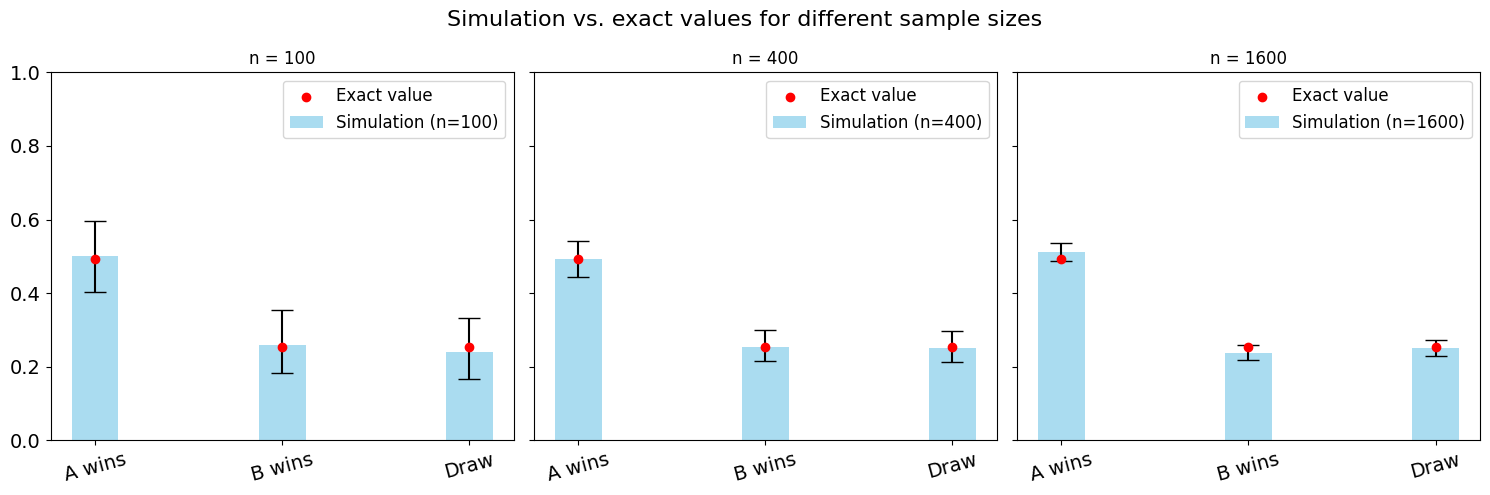

In [2]:
import random, math
from functools import lru_cache
from fractions import Fraction
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Wilson confidence interval
# ------------------------------------------------------------
def wilson_interval(k, n, z=1.96):
    if n == 0:
        return (0.0, 0.0)
    phat = k / n
    denom = 1 + z**2 / n
    center = (phat + z**2 / (2*n)) / denom
    halfwidth = z / denom * math.sqrt(phat*(1 - phat)/n + z**2 / (4*n**2))
    return center - halfwidth, center + halfwidth

# ------------------------------------------------------------
# Simulation of a single game
# ------------------------------------------------------------
def simulate_game(p, A, B):
    m = len(p)
    chips_A = A[:]
    chips_B = B[:]

    def finished(chips):
        return all(c == 0 for c in chips)

    while True:
        r = random.random()
        s = 0
        for j in range(m):
            s += p[j]
            if r < s:
                field = j
                break

        if chips_A[field] > 0:
            chips_A[field] -= 1
        if chips_B[field] > 0:
            chips_B[field] -= 1

        if finished(chips_A) and finished(chips_B):
            return 'U'
        elif finished(chips_A):
            return 'A'
        elif finished(chips_B):
            return 'B'

# ------------------------------------------------------------
# Monte Carlo simulation with confidence intervals
# ------------------------------------------------------------
def simulate_many(p, A, B, n_runs=10000):
    counts = {'A': 0, 'B': 0, 'U': 0}
    for _ in range(n_runs):
        counts[simulate_game(p, A, B)] += 1

    results = {}
    for k in counts:
        phat = counts[k] / n_runs
        low, high = wilson_interval(counts[k], n_runs)
        results[k] = {"p_hat": phat, "CI_low": low, "CI_high": high}
    return results

# ------------------------------------------------------------
# Exact computation using Fraction
# ------------------------------------------------------------
def exact_probabilities_fraction(p, A, B):
    p = tuple(Fraction(pi) for pi in p)
    A = tuple(A)
    B = tuple(B)

    @lru_cache(None)
    def P_A(V, W):
        sum_V, sum_W = sum(V), sum(W)
        if sum_V == 0 and sum_W == 0: return Fraction(0, 1)
        if sum_V == 0: return Fraction(1, 1)
        if sum_W == 0: return Fraction(0, 1)

        s = sum(pj for pj, vj, wj in zip(p, V, W) if vj or wj)
        if s == 0: return Fraction(0, 1)

        prob = Fraction(0, 1)
        for j, pj in enumerate(p):
            if V[j] or W[j]:
                Vn = V[:j] + (max(0, V[j]-1),) + V[j+1:]
                Wn = W[:j] + (max(0, W[j]-1),) + W[j+1:]
                prob += (pj / s) * P_A(Vn, Wn)
        return prob

    PA = P_A(A, B)
    PB = P_A(B, A)
    PU = Fraction(1, 1) - PA - PB
    return PA, PB, PU

# ------------------------------------------------------------
# Comparison for multiple sample sizes + table and plot
# ------------------------------------------------------------
if __name__ == "__main__":
    p = [Fraction(1, 2), Fraction(1, 3), Fraction(1, 6)]
    A = [3, 2, 1]
    B = [4, 2, 0]
    n_values = [100, 400, 1600]

    exact_vals = exact_probabilities_fraction(p, A, B)
    exact_floats = [float(v) for v in exact_vals]
    labels = ["A wins", "B wins", "Draw"]

    fig, axes = plt.subplots(1, len(n_values), figsize=(5*len(n_values), 5), sharey=True)
    for ax in axes:
        ax.tick_params(axis='y', labelsize=14)

    for ax, n in zip(axes, n_values):
        sim = simulate_many([float(x) for x in p], A, B, n)
        sim_vals = [sim[k]["p_hat"] for k in ['A', 'B', 'U']]
        ci_lows = [sim[k]["CI_low"] for k in ['A', 'B', 'U']]
        ci_highs = [sim[k]["CI_high"] for k in ['A', 'B', 'U']]
        yerr = [[sim_vals[i] - ci_lows[i] for i in range(3)],
                [ci_highs[i] - sim_vals[i] for i in range(3)]]

        ax.bar(range(3), sim_vals, yerr=yerr, align='center', alpha=0.7, capsize=8,
               label=f"Simulation (n={n})", color='skyblue', width=0.25)
        ax.scatter(range(3), exact_floats, color='red', zorder=5, label="Exact value")
        ax.set_xticks(range(3))
        ax.set_xticklabels(labels, rotation=15, fontsize=14)
        ax.set_ylim(0, 1)
        ax.set_title(f"n = {n}")
        ax.legend(fontsize=12)

        # Console output for this n
        print(f"\n--- Results for n = {n} ---")
        for key, name, exact_val in zip(['A', 'B', 'U'], labels, exact_vals):
            phat = sim[key]["p_hat"]
            low  = sim[key]["CI_low"]
            high = sim[key]["CI_high"]
            deviation = abs(phat - float(exact_val))
            print(f"{name:15s}: phat = {phat:.5f}, CI = ({low:.5f} – {high:.5f}), "
                  f"deviation = {deviation:.5f}, exact = {exact_val}")

    fig.suptitle("Simulation vs. exact values for different sample sizes", fontsize=16)
    plt.tight_layout()
    print()
    plt.show()
